<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_DenseNet201_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 02:14:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0    29W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6204676940105855
GPU (s):
0.03222768902196549
GPU speedup over CPU: 19x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.densenet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 31s 61ms/step - loss: 0.6287 - accuracy: 0.7318 - val_loss: 0.5298 - val_accuracy: 0.7741
Epoch 2/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5263 - accuracy: 0.7750 - val_loss: 0.4726 - val_accuracy: 0.7949
Epoch 3/100
360/360 [==============================] - 18s 50ms/step - loss: 0.5038 - accuracy: 0.7835 - val_loss: 0.4571 - val_accuracy: 0.8036
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.4866 - accuracy: 0.7927 - val_loss: 0.4482 - val_accuracy: 0.8119
Epoch 5/100
360/360 [==============================] - 18s 49ms/step - loss: 0.4774 - accuracy: 0.7990 - val_loss: 0.4583 - val_accuracy: 0.8025
Epoch 6/100
360/360 [==============================] - 17s 48ms/step - loss: 0.4660 -

Epoch 56/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3611 - accuracy: 0.8456 - val_loss: 0.3915 - val_accuracy: 0.8414
Epoch 57/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3649 - accuracy: 0.8511 - val_loss: 0.3892 - val_accuracy: 0.8392
Epoch 58/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3628 - accuracy: 0.8470 - val_loss: 0.3901 - val_accuracy: 0.8406
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.3654 - accuracy: 0.8471 - val_loss: 0.3919 - val_accuracy: 0.8416
Epoch 60/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3639 - accuracy: 0.8488 - val_loss: 0.3893 - val_accuracy: 0.8385
Epoch 61/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3651 - accuracy: 0.8478 - val_loss: 0.3906 - val_accuracy: 0.8466
Epoch 62/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3590 - accuracy: 0.8507 - val_loss: 0.3961 -

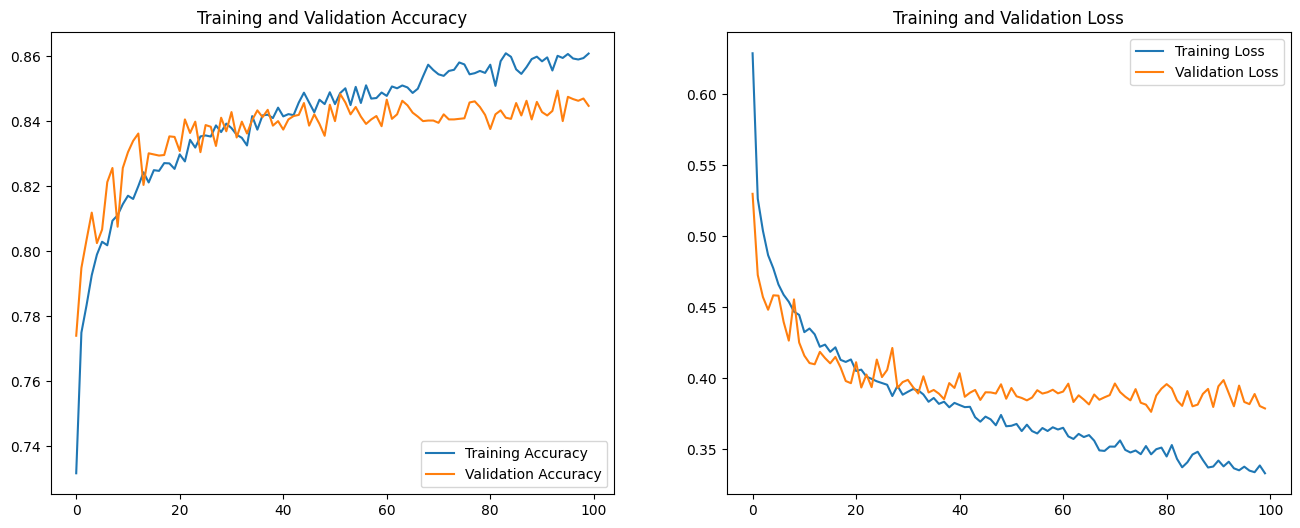

In [6]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 54ms/step - loss: 0.7165 - accuracy: 0.6936 - val_loss: 0.5961 - val_accuracy: 0.7362
Epoch 2/100
360/360 [==============================] - 21s 57ms/step - loss: 0.6069 - accuracy: 0.7394 - val_loss: 0.5417 - val_accuracy: 0.7737
Epoch 3/100
360/360 [==============================] - 18s 49ms/step - loss: 0.5865 - accuracy: 0.7483 - val_loss: 0.5347 - val_accuracy: 0.7794
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5667 - accuracy: 0.7548 - val_loss: 0.5215 - val_accuracy: 0.7780
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5575 - accuracy: 0.7592 - val_loss: 0.5187 - val_accuracy: 0.7713
Epoch 6/100
360/360 [==============================] - 17s 48ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4406 - accuracy: 0.8174 - val_loss: 0.4404 - val_accuracy: 0.8161
Epoch 57/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4445 - accuracy: 0.8112 - val_loss: 0.4514 - val_accuracy: 0.8114
Epoch 58/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4447 - accuracy: 0.8117 - val_loss: 0.4388 - val_accuracy: 0.8190
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4367 - accuracy: 0.8183 - val_loss: 0.4350 - val_accuracy: 0.8222
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4388 - accuracy: 0.8171 - val_loss: 0.4337 - val_accuracy: 0.8237
Epoch 61/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4390 - accuracy: 0.8141 - val_loss: 0.4450 - val_accuracy: 0.8201
Epoch 62/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4418 - accuracy: 0.8121 - val_loss: 0.4390 -

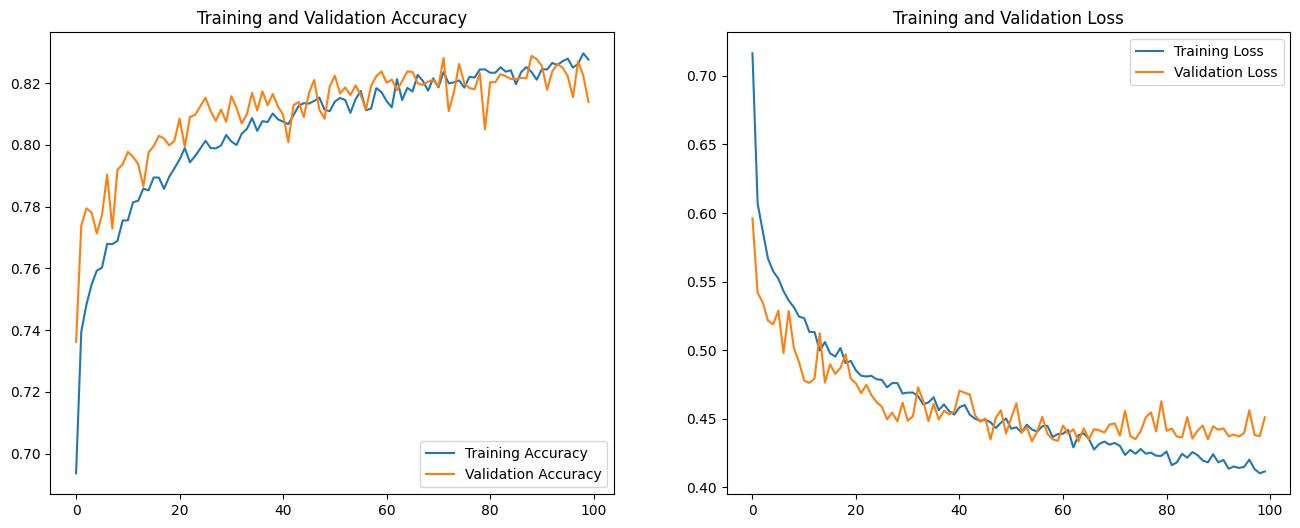

In [7]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 1.1310 - accuracy: 0.5943 - val_loss: 0.7223 - val_accuracy: 0.6883
Epoch 2/100
360/360 [==============================] - 17s 48ms/step - loss: 0.7844 - accuracy: 0.6604 - val_loss: 0.6860 - val_accuracy: 0.6992
Epoch 3/100
360/360 [==============================] - 17s 47ms/step - loss: 0.7374 - accuracy: 0.6827 - val_loss: 0.6952 - val_accuracy: 0.6969
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.7091 - accuracy: 0.6933 - val_loss: 0.6574 - val_accuracy: 0.7169
Epoch 5/100
360/360 [==============================] - 18s 49ms/step - loss: 0.6990 - accuracy: 0.7001 - val_loss: 0.6425 - val_accuracy: 0.7225
Epoch 6/100
360/360 [==============================] - 17s 48ms/step - loss: 0.6813 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 16s 46ms/step - loss: 0.5440 - accuracy: 0.7747 - val_loss: 0.5359 - val_accuracy: 0.7794
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5421 - accuracy: 0.7750 - val_loss: 0.5200 - val_accuracy: 0.7876
Epoch 58/100
360/360 [==============================] - 17s 46ms/step - loss: 0.5447 - accuracy: 0.7716 - val_loss: 0.5264 - val_accuracy: 0.7860
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 0.5436 - accuracy: 0.7751 - val_loss: 0.5309 - val_accuracy: 0.7807
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5423 - accuracy: 0.7733 - val_loss: 0.5377 - val_accuracy: 0.7793
Epoch 61/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5442 - accuracy: 0.7741 - val_loss: 0.5277 - val_accuracy: 0.7879
Epoch 62/100
360/360 [==============================] - 16s 46ms/step - loss: 0.5419 - accuracy: 0.7742 - val_loss: 0.5294 -

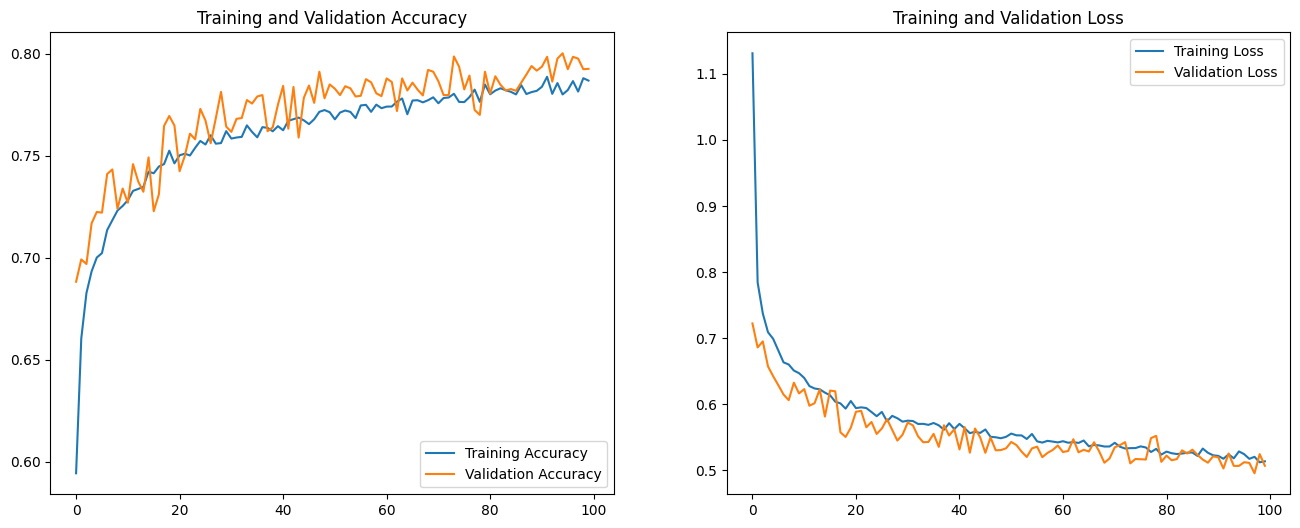

In [8]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 29s 58ms/step - loss: 1.4435 - accuracy: 0.2912 - val_loss: 1.4168 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 17s 47ms/step - loss: 1.4184 - accuracy: 0.3053 - val_loss: 1.3788 - val_accuracy: 0.4243
Epoch 3/100
360/360 [==============================] - 17s 47ms/step - loss: 1.3865 - accuracy: 0.3507 - val_loss: 1.3842 - val_accuracy: 0.3137
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 1.3472 - accuracy: 0.3927 - val_loss: 1.2823 - val_accuracy: 0.4281
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 1.3237 - accuracy: 0.4035 - val_loss: 1.2616 - val_accuracy: 0.4295
Epoch 6/100
360/360 [==============================] - 17s 46ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 19s 53ms/step - loss: 1.2070 - accuracy: 0.4500 - val_loss: 1.1254 - val_accuracy: 0.5026
Epoch 57/100
360/360 [==============================] - 16s 46ms/step - loss: 1.2016 - accuracy: 0.4587 - val_loss: 1.1403 - val_accuracy: 0.4651
Epoch 58/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1989 - accuracy: 0.4552 - val_loss: 1.1326 - val_accuracy: 0.5073
Epoch 59/100
360/360 [==============================] - 17s 46ms/step - loss: 1.2025 - accuracy: 0.4531 - val_loss: 1.1391 - val_accuracy: 0.5021
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 1.2060 - accuracy: 0.4507 - val_loss: 1.1527 - val_accuracy: 0.4972
Epoch 61/100
360/360 [==============================] - 17s 46ms/step - loss: 1.1988 - accuracy: 0.4550 - val_loss: 1.1318 - val_accuracy: 0.4984
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 1.2014 - accuracy: 0.4514 - val_loss: 1.2273 -

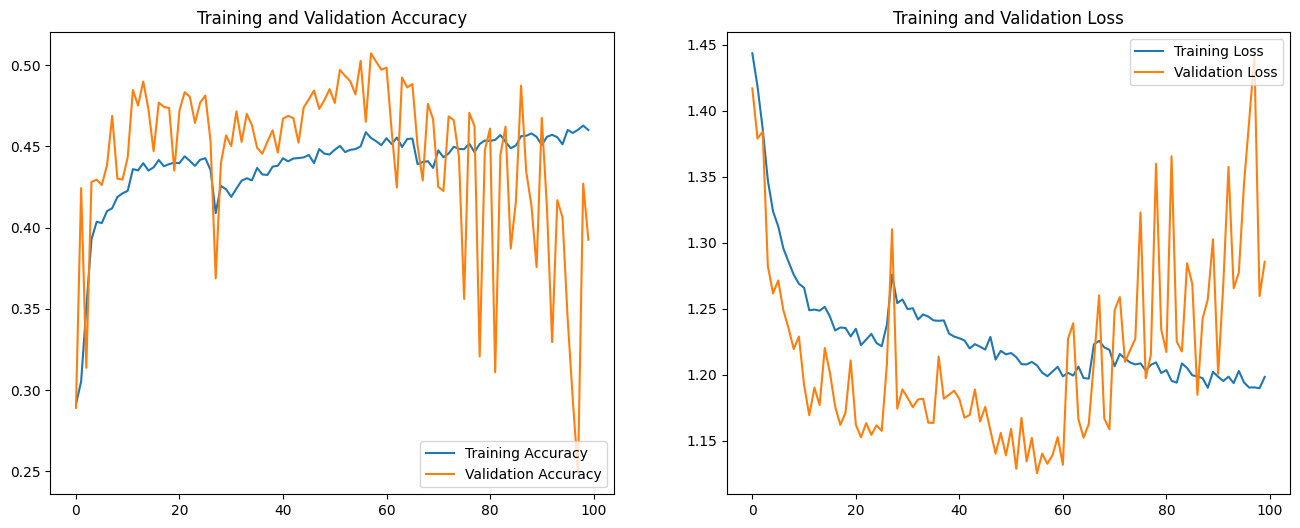

In [9]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 0.5713 - accuracy: 0.7628 - val_loss: 0.4741 - val_accuracy: 0.7947
Epoch 2/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4535 - accuracy: 0.8077 - val_loss: 0.4103 - val_accuracy: 0.8279
Epoch 3/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4312 - accuracy: 0.8223 - val_loss: 0.3761 - val_accuracy: 0.8451
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.4143 - accuracy: 0.8297 - val_loss: 0.3664 - val_accuracy: 0.8479
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 0.3981 - accuracy: 0.8344 - val_loss: 0.3711 - val_accuracy: 0.8466
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 0.3889 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 16s 46ms/step - loss: 0.2792 - accuracy: 0.8893 - val_loss: 0.2564 - val_accuracy: 0.9007
Epoch 57/100
360/360 [==============================] - 16s 46ms/step - loss: 0.2855 - accuracy: 0.8880 - val_loss: 0.2750 - val_accuracy: 0.8946
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2778 - accuracy: 0.8889 - val_loss: 0.2743 - val_accuracy: 0.8922
Epoch 59/100
360/360 [==============================] - 17s 46ms/step - loss: 0.2791 - accuracy: 0.8932 - val_loss: 0.2741 - val_accuracy: 0.8956
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 0.2789 - accuracy: 0.8892 - val_loss: 0.2663 - val_accuracy: 0.9001
Epoch 61/100
360/360 [==============================] - 17s 47ms/step - loss: 0.2763 - accuracy: 0.8904 - val_loss: 0.2666 - val_accuracy: 0.8963
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 0.2772 - accuracy: 0.8905 - val_loss: 0.2617 -

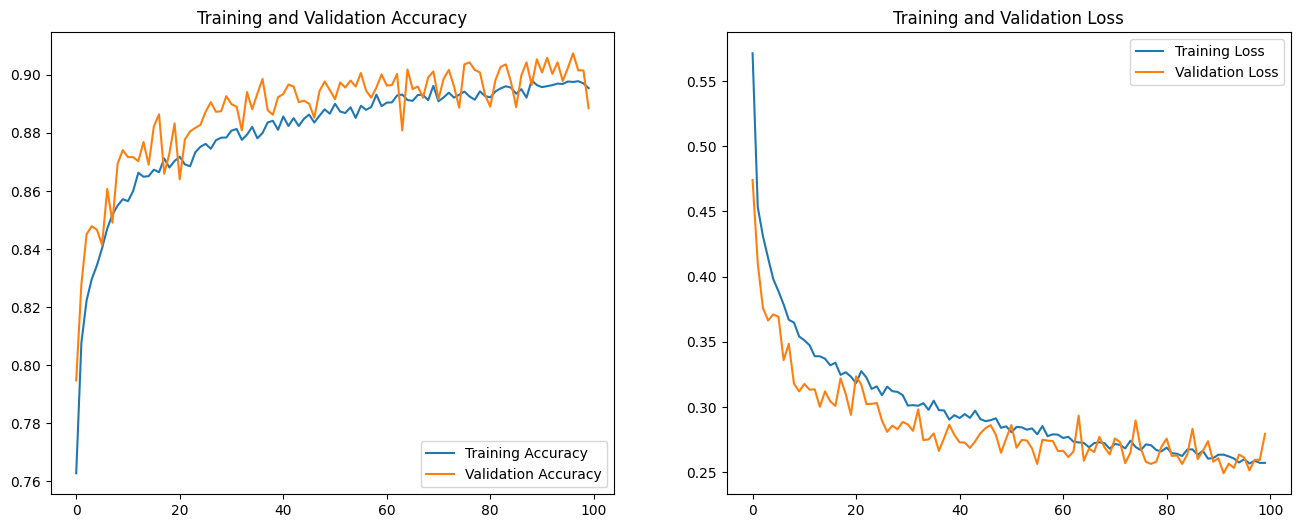

In [10]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 54ms/step - loss: 1.1972 - accuracy: 0.4661 - val_loss: 1.0732 - val_accuracy: 0.5036
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 1.0882 - accuracy: 0.5156 - val_loss: 1.0416 - val_accuracy: 0.5474
Epoch 3/100
360/360 [==============================] - 17s 46ms/step - loss: 1.0521 - accuracy: 0.5325 - val_loss: 1.0057 - val_accuracy: 0.5335
Epoch 4/100
360/360 [==============================] - 16s 45ms/step - loss: 1.0346 - accuracy: 0.5398 - val_loss: 1.0221 - val_accuracy: 0.5406
Epoch 5/100
360/360 [==============================] - 17s 46ms/step - loss: 1.0224 - accuracy: 0.5512 - val_loss: 0.9578 - val_accuracy: 0.5821
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 16s 45ms/step - loss: 0.8978 - accuracy: 0.6214 - val_loss: 0.8372 - val_accuracy: 0.6481
Epoch 57/100
360/360 [==============================] - 17s 46ms/step - loss: 0.8961 - accuracy: 0.6222 - val_loss: 0.8519 - val_accuracy: 0.6388
Epoch 58/100
360/360 [==============================] - 17s 46ms/step - loss: 0.8906 - accuracy: 0.6250 - val_loss: 0.8385 - val_accuracy: 0.6483
Epoch 59/100
360/360 [==============================] - 17s 46ms/step - loss: 0.8913 - accuracy: 0.6285 - val_loss: 0.8326 - val_accuracy: 0.6440
Epoch 60/100
360/360 [==============================] - 16s 45ms/step - loss: 0.8999 - accuracy: 0.6232 - val_loss: 0.8471 - val_accuracy: 0.6438
Epoch 61/100
360/360 [==============================] - 16s 45ms/step - loss: 0.8881 - accuracy: 0.6327 - val_loss: 0.8417 - val_accuracy: 0.6518
Epoch 62/100
360/360 [==============================] - 16s 45ms/step - loss: 0.8943 - accuracy: 0.6246 - val_loss: 0.8300 -

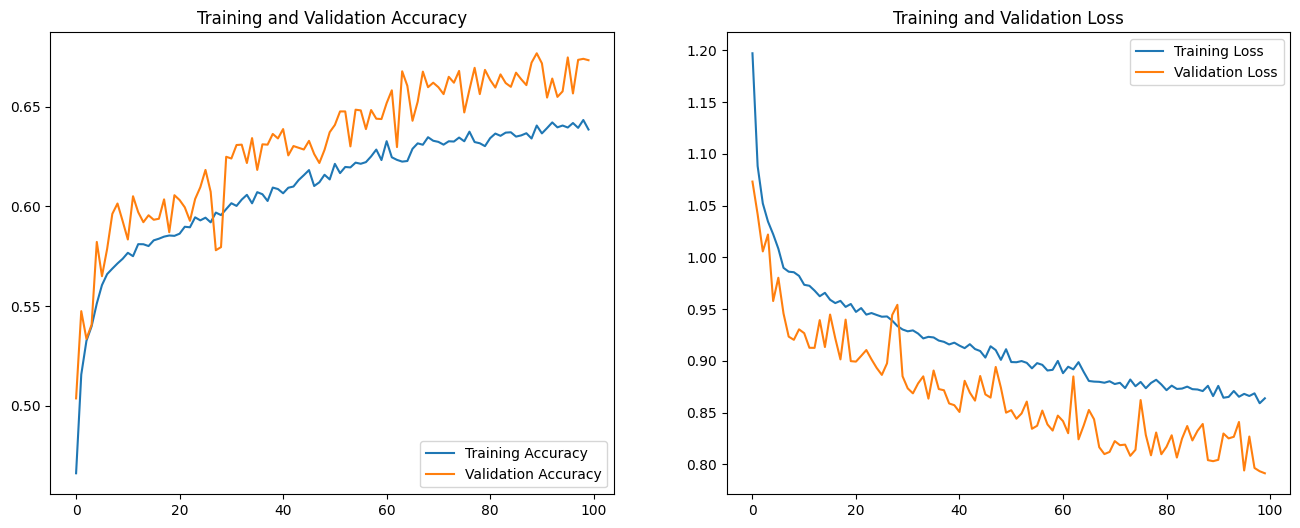

In [11]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 52ms/step - loss: 0.9043 - accuracy: 0.6209 - val_loss: 0.7702 - val_accuracy: 0.6643
Epoch 2/100
360/360 [==============================] - 17s 46ms/step - loss: 0.7839 - accuracy: 0.6596 - val_loss: 0.7259 - val_accuracy: 0.6799
Epoch 3/100
360/360 [==============================] - 16s 46ms/step - loss: 0.7552 - accuracy: 0.6712 - val_loss: 0.7138 - val_accuracy: 0.6886
Epoch 4/100
360/360 [==============================] - 17s 47ms/step - loss: 0.7345 - accuracy: 0.6749 - val_loss: 0.6909 - val_accuracy: 0.6945
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 0.7277 - accuracy: 0.6847 - val_loss: 0.6915 - val_accuracy: 0.6976
Epoch 6/100
360/360 [==============================] - 17s 46ms/step - loss: 0.7148 - accuracy: 0.6

Epoch 62/100
360/360 [==============================] - 17s 46ms/step - loss: 0.5969 - accuracy: 0.7420 - val_loss: 0.6491 - val_accuracy: 0.7225
Epoch 63/100
360/360 [==============================] - 16s 46ms/step - loss: 0.5950 - accuracy: 0.7435 - val_loss: 0.6451 - val_accuracy: 0.7247
Epoch 64/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5923 - accuracy: 0.7427 - val_loss: 0.6411 - val_accuracy: 0.7258
Epoch 65/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5888 - accuracy: 0.7483 - val_loss: 0.6547 - val_accuracy: 0.7176
Epoch 66/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5938 - accuracy: 0.7444 - val_loss: 0.6457 - val_accuracy: 0.7239
Epoch 67/100
360/360 [==============================] - 17s 46ms/step - loss: 0.6005 - accuracy: 0.7384 - val_loss: 0.6433 - val_accuracy: 0.7273
Epoch 68/100
360/360 [==============================] - 18s 51ms/step - loss: 0.5954 - accuracy: 0.7418 - val_loss: 0.6440 -

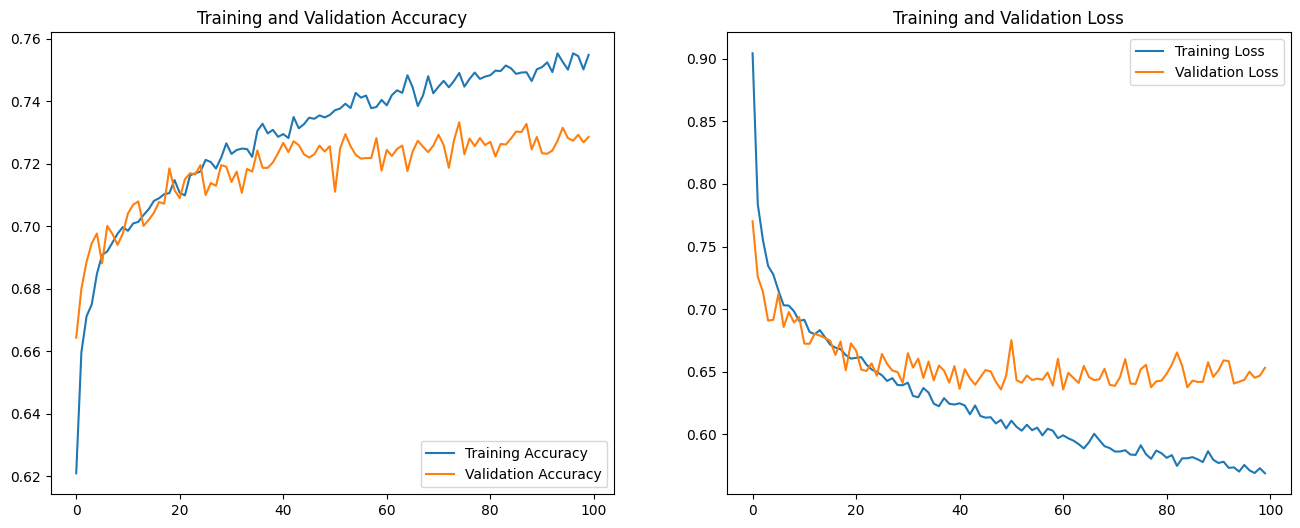

In [12]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 1.4469 - accuracy: 0.2867 - val_loss: 1.4168 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 19s 52ms/step - loss: 1.4202 - accuracy: 0.2929 - val_loss: 1.3989 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 19s 53ms/step - loss: 1.3975 - accuracy: 0.3114 - val_loss: 1.3438 - val_accuracy: 0.3232
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 1.3604 - accuracy: 0.3391 - val_loss: 1.3153 - val_accuracy: 0.3394
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 1.3326 - accuracy: 0.3542 - val_loss: 1.2811 - val_accuracy: 0.3730
Epoch 6/100
360/360 [==============================] - 17s 46ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1474 - accuracy: 0.4848 - val_loss: 1.0766 - val_accuracy: 0.5035
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 1.1399 - accuracy: 0.4858 - val_loss: 1.1306 - val_accuracy: 0.4555
Epoch 58/100
360/360 [==============================] - 17s 47ms/step - loss: 1.1431 - accuracy: 0.4888 - val_loss: 1.1126 - val_accuracy: 0.4660
Epoch 59/100
360/360 [==============================] - 17s 46ms/step - loss: 1.1393 - accuracy: 0.4878 - val_loss: 1.1616 - val_accuracy: 0.4137
Epoch 60/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1444 - accuracy: 0.4829 - val_loss: 1.0514 - val_accuracy: 0.5236
Epoch 61/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1450 - accuracy: 0.4822 - val_loss: 1.1745 - val_accuracy: 0.4154
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 1.1346 - accuracy: 0.4906 - val_loss: 1.1075 -

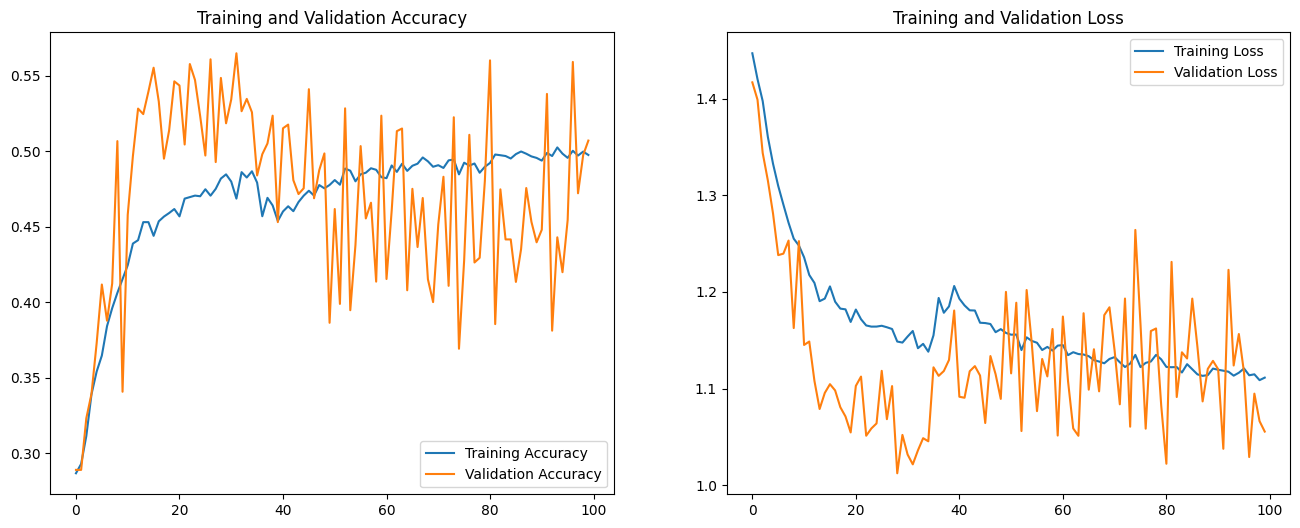

In [13]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 0.5937 - accuracy: 0.7550 - val_loss: 0.4812 - val_accuracy: 0.8067
Epoch 2/100
360/360 [==============================] - 18s 49ms/step - loss: 0.4739 - accuracy: 0.7994 - val_loss: 0.4398 - val_accuracy: 0.8168
Epoch 3/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4488 - accuracy: 0.8118 - val_loss: 0.4104 - val_accuracy: 0.8326
Epoch 4/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4272 - accuracy: 0.8193 - val_loss: 0.3936 - val_accuracy: 0.8387
Epoch 5/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4265 - accuracy: 0.8206 - val_loss: 0.4116 - val_accuracy: 0.8229
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4200 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 17s 46ms/step - loss: 0.3157 - accuracy: 0.8723 - val_loss: 0.3022 - val_accuracy: 0.8826
Epoch 57/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3101 - accuracy: 0.8750 - val_loss: 0.3152 - val_accuracy: 0.8763
Epoch 58/100
360/360 [==============================] - 16s 45ms/step - loss: 0.3175 - accuracy: 0.8713 - val_loss: 0.3108 - val_accuracy: 0.8819
Epoch 59/100
360/360 [==============================] - 16s 46ms/step - loss: 0.3111 - accuracy: 0.8743 - val_loss: 0.3099 - val_accuracy: 0.8779
Epoch 60/100
360/360 [==============================] - 17s 46ms/step - loss: 0.3169 - accuracy: 0.8736 - val_loss: 0.3121 - val_accuracy: 0.8757
Epoch 61/100
360/360 [==============================] - 16s 46ms/step - loss: 0.3124 - accuracy: 0.8754 - val_loss: 0.3257 - val_accuracy: 0.8724
Epoch 62/100
360/360 [==============================] - 17s 46ms/step - loss: 0.3169 - accuracy: 0.8722 - val_loss: 0.3064 -

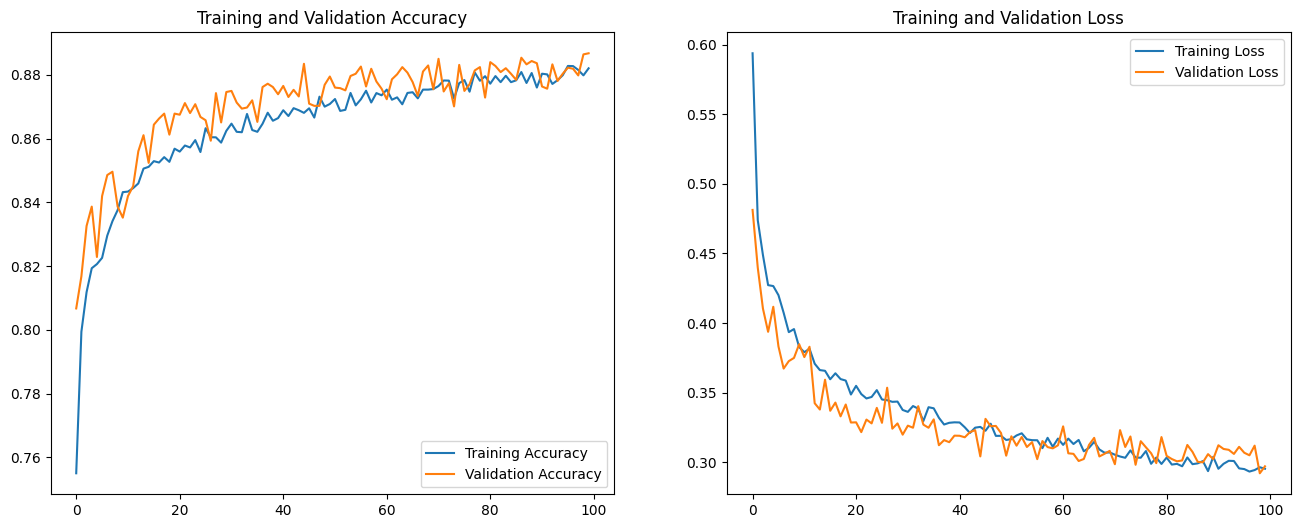

In [14]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 1.4413 - accuracy: 0.2948 - val_loss: 1.4067 - val_accuracy: 0.3868
Epoch 2/100
360/360 [==============================] - 17s 46ms/step - loss: 1.4028 - accuracy: 0.3294 - val_loss: 1.3570 - val_accuracy: 0.4057
Epoch 3/100
360/360 [==============================] - 17s 47ms/step - loss: 1.3503 - accuracy: 0.3710 - val_loss: 1.3029 - val_accuracy: 0.3748
Epoch 4/100
360/360 [==============================] - 17s 47ms/step - loss: 1.3178 - accuracy: 0.3926 - val_loss: 1.3037 - val_accuracy: 0.3876
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 1.2865 - accuracy: 0.4098 - val_loss: 1.2050 - val_accuracy: 0.4505
Epoch 6/100
360/360 [==============================] - 16s 46ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 17s 47ms/step - loss: 1.1152 - accuracy: 0.4996 - val_loss: 0.9962 - val_accuracy: 0.5792
Epoch 57/100
360/360 [==============================] - 17s 46ms/step - loss: 1.1098 - accuracy: 0.5026 - val_loss: 0.9717 - val_accuracy: 0.5813
Epoch 58/100
360/360 [==============================] - 17s 46ms/step - loss: 1.1059 - accuracy: 0.5054 - val_loss: 0.9783 - val_accuracy: 0.5700
Epoch 59/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1094 - accuracy: 0.5012 - val_loss: 0.9890 - val_accuracy: 0.5834
Epoch 60/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1162 - accuracy: 0.5019 - val_loss: 1.0333 - val_accuracy: 0.5439
Epoch 61/100
360/360 [==============================] - 16s 46ms/step - loss: 1.1041 - accuracy: 0.5065 - val_loss: 1.0111 - val_accuracy: 0.5582
Epoch 62/100
360/360 [==============================] - 17s 46ms/step - loss: 1.1084 - accuracy: 0.5022 - val_loss: 1.0507 -

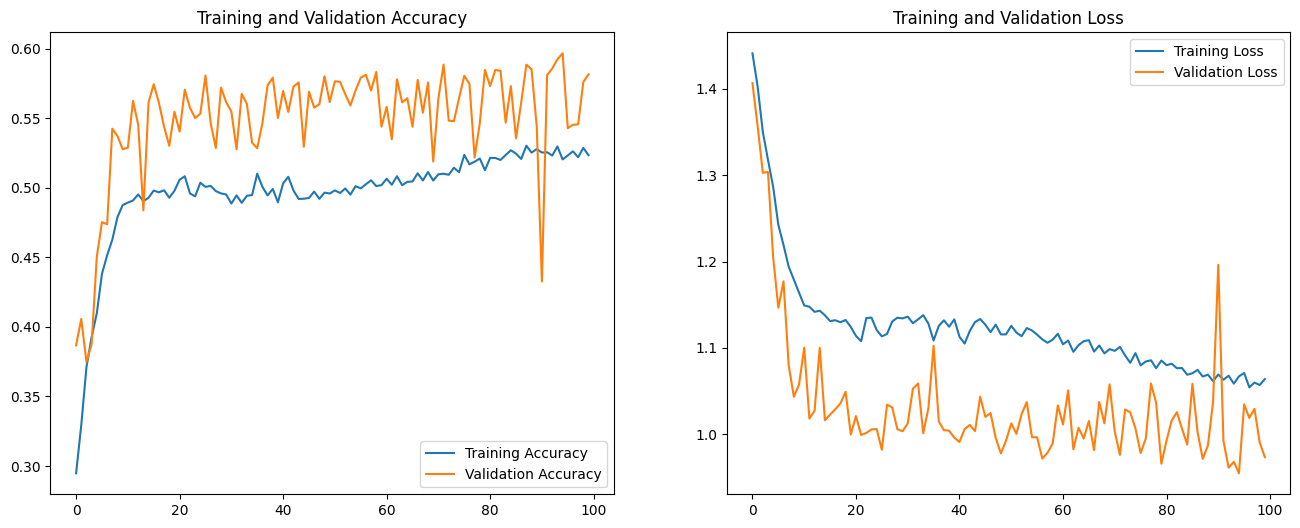

In [15]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 0.7047 - accuracy: 0.6956 - val_loss: 0.5885 - val_accuracy: 0.7444
Epoch 2/100
360/360 [==============================] - 17s 47ms/step - loss: 0.6086 - accuracy: 0.7324 - val_loss: 0.5569 - val_accuracy: 0.7510
Epoch 3/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5834 - accuracy: 0.7432 - val_loss: 0.5316 - val_accuracy: 0.7654
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5741 - accuracy: 0.7488 - val_loss: 0.5377 - val_accuracy: 0.7664
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5565 - accuracy: 0.7585 - val_loss: 0.5194 - val_accuracy: 0.7730
Epoch 6/100
360/360 [==============================] - 17s 46ms/step - loss: 0.5509 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4245 - accuracy: 0.8214 - val_loss: 0.4558 - val_accuracy: 0.8104
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4325 - accuracy: 0.8165 - val_loss: 0.4479 - val_accuracy: 0.8088
Epoch 58/100
360/360 [==============================] - 17s 48ms/step - loss: 0.4283 - accuracy: 0.8209 - val_loss: 0.4411 - val_accuracy: 0.8124
Epoch 59/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4268 - accuracy: 0.8205 - val_loss: 0.4471 - val_accuracy: 0.8168
Epoch 60/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4314 - accuracy: 0.8207 - val_loss: 0.4430 - val_accuracy: 0.8187
Epoch 61/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4244 - accuracy: 0.8204 - val_loss: 0.4320 - val_accuracy: 0.8208
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4278 - accuracy: 0.8189 - val_loss: 0.4342 -

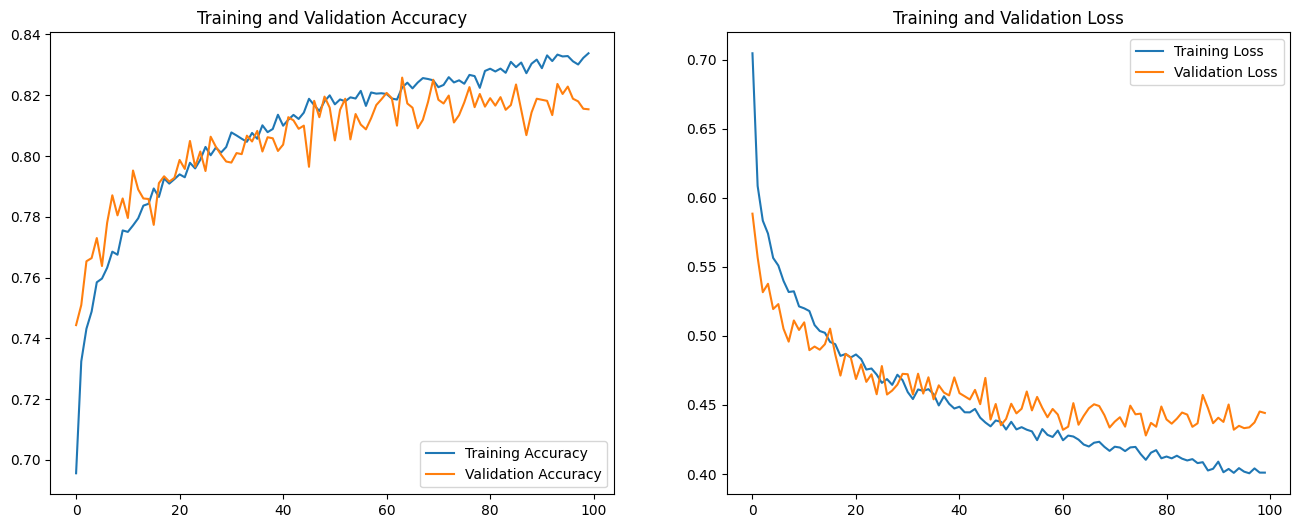

In [16]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [17]:
# !mkdir densenet169_nontrainable
# pd.DataFrame(res_rgb).to_csv("densenet169_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("densenet169_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("densenet169_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("densenet169_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("densenet169_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("densenet169_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("densenet169_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("densenet169_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("densenet169_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("densenet169_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("densenet169_nontrainable/res_ydbdr_nonpre.csv", index=False)